# Capstone Course Final Assignment

![alt text](https://million-wallpapers.com/wallpapers/3/79/509711781858534.jpg "Logo Title Text 1")

## Introduction

### In a world where competitiveness is at his highest peak, a simple, modest pastry is trying to fit into Paris. As anyone else, this restaurant wants to be very successful. In order to accomplish this dream they know that the very first step to make it is to decide a location to sell the deliciousness they know they can produce.
### After some brainstorning they realized they had to come up with certain factors that will impact their decision to choose a location. After a while they come up with security, competition and population. In a city as big as Paris, they wanted to go to a safe location where crime could not affect the costs that they might have. Also, competition must be low so that they could stand out among other restaurants. Finally, without enough clients they wouldn't make it so it's important that they settle in an area with a lot of populations.
### So, now that the factors are decided, it's important to analyze data to make the best decision possible.

In [26]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.request import urlopen
import random
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import json # library to handle JSON files
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
#import k-means from clustering stage
from sklearn.cluster import KMeans

## DataFrame
### In order to make the best decision, based on the factors already defined, they had to get the information needed to make the mandatory analysis. After a few research they came up the the dataframe below. The dataframe is consisted in the 20 arrondissements of Paris followed by their location (with latitude and longitude coordinates), population and crime rate.
### (As a crime rate was not found untill this fate and for the sake of the sucess of this analysis, it was decided to use random crime rates)

In [27]:
df = pd.read_csv('https://opendata.paris.fr/explore/dataset/arrondissements/download/?format=csv&timezone=Europe/London&lang=fr&use_labels_for_header=true&csv_separator=%3B', sep = ';')
df = df[['L_AROFF','Geometry X Y']]
df1 = df['Geometry X Y'].str.split(',', expand=True)
df['Latitude'] = df1[0]
df['Longitude'] = df1[1]
df = df.drop('Geometry X Y',axis = 1)
population = [235469,35469,59947,41831,142661,60235,187760,148339,183117,138218,196884,16338,53415,20410,169375,92660,167706,27795,37053,196143]
df['Population'] = population
crimerate = [random.randrange(1, 50, 1) for i in range(20)]
df['CrimeRate'] = crimerate
df

,L_AROFF,Latitude,Longitude,Population,CrimeRate
0,Temple,48.86287238,2.3600009859,235469,10
1,Bourse,48.8682792225,2.34280254689,35469,45
2,Batignolles-Monceau,48.887326522,2.30677699057,59947,6
3,Palais-Bourbon,48.8561744288,2.31218769148,41831,31
4,Hôtel-de-Ville,48.8543414263,2.35762962032,142661,9
5,Élysée,48.8727208374,2.3125540224,60235,14
6,Buttes-Montmartre,48.892569268,2.34816051956,187760,6
7,Louvre,48.8625627018,2.33644336205,148339,40
8,Popincourt,48.8590592213,2.3800583082,183117,6
9,Gobelins,48.8283880317,2.36227244042,138218,16


## Data analysis
## EDA
### After cleaning the data, some analysis is mandatory to come up with a decision. They started with some EDA (Explanatory Data Analysis) and realized the most safe places to set up a business as well as the most populated places where there was more potencial for a higher number of clients.

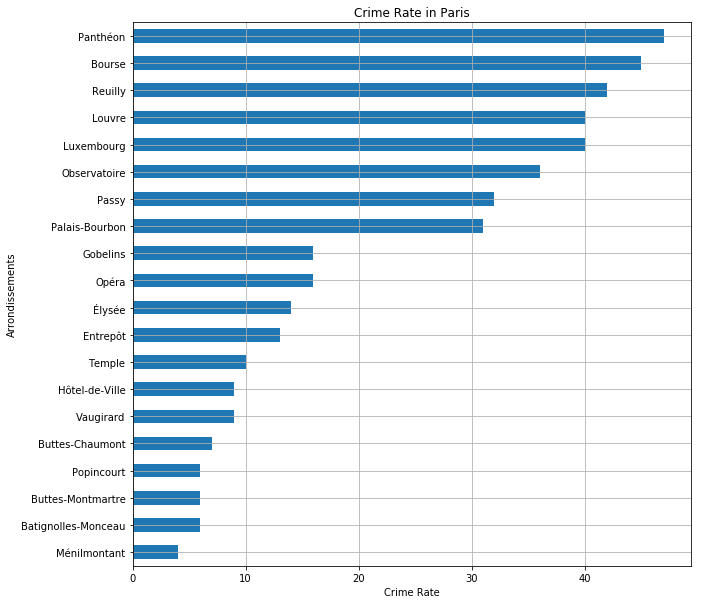

In [28]:
df.set_index('L_AROFF')['CrimeRate'].sort_values().plot(kind='barh', grid=True, figsize=(10,10))
plt.xlabel('Crime Rate')
plt.ylabel('Arrondissements')
plt.title('Crime Rate in Paris')
plt.show()

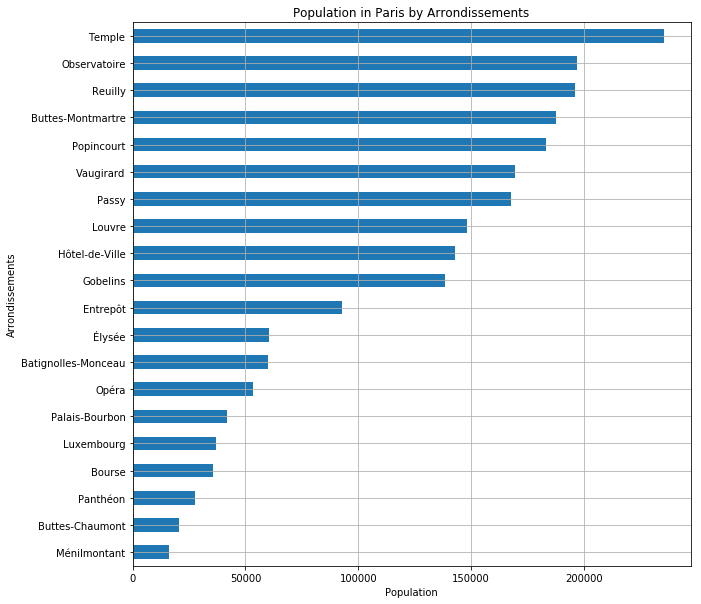

In [29]:
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

df.set_index('L_AROFF')['Population'].sort_values().plot(kind='barh', grid=True, figsize=(10,10))
plt.xlabel('Population')
plt.ylabel('Arrondissements')
plt.title('Population in Paris by Arrondissements')
plt.show()

## Cluster Analysis
### After sorting the data in the EDA, where they got information in safety and client potencial, the last factor analyzed is missing: venues competition. Their objective was to find anarrondissement where there was not a lot of restaurants, so that they could grow and build a community around their restaurant. In order to do it, it was utilized a data from Foursquare to form a dataframe to classify each arrondissement in terms of most common venues. That way we could cluster the arrondissements considering their similarities and therefore choose the best cluster to set up a restaurant. 

In [30]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    LIMIT = 100
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [31]:
CLIENT_ID="QE2ODWO2XJJTQYI2DKWFXYPZILBBZGFWPDY01YMESE0HILXL"
CLIENT_SECRET="PZVH1IG3WJO11AJS4VF350UCTBNNUO3NURBYWXCKLNAJNEWE"
VERSION="20200412"

In [32]:
df = df.rename(columns={"L_AROFF": "Neighborhood"})

In [33]:
df = df.rename(columns={"L_AROFF": "Neighborhood"})
paris_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

paris_onehot = pd.get_dummies(paris_venues[['Venue Category']], prefix="", prefix_sep="")


paris_onehot['Neighborhood'] = paris_venues['Neighborhood'] 


fixed_columns = [paris_onehot.columns[-1]] + list(paris_onehot.columns[:-1])
paris_onehot = paris_onehot[fixed_columns]

paris_grouped = paris_onehot.groupby('Neighborhood').mean().reset_index()

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = paris_grouped['Neighborhood']

for ind in np.arange(paris_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(paris_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

# set number of clusters
kclusters = 5

paris_grouped_clustering = paris_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(paris_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 



# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

paris_merged = df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
paris_merged = paris_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')


Temple
Bourse
Batignolles-Monceau
Palais-Bourbon
Hôtel-de-Ville
Élysée
Buttes-Montmartre
Louvre
Popincourt
Gobelins
Observatoire
Ménilmontant
Opéra
Buttes-Chaumont
Vaugirard
Entrepôt
Passy
Panthéon
Luxembourg
Reuilly


In [34]:
paris_merged.sort_values(by='Cluster Labels', ascending=True).head(20)

,Neighborhood,Latitude,Longitude,Population,CrimeRate,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Batignolles-Monceau,48.887326522,2.30677699057,59947,6,0,French Restaurant,Hotel,Italian Restaurant,Bakery,Plaza,Bistro,Café,Japanese Restaurant,Chinese Restaurant,Restaurant
3,Palais-Bourbon,48.8561744288,2.31218769148,41831,31,0,Hotel,French Restaurant,Italian Restaurant,Café,Plaza,Bistro,History Museum,Art Museum,Cocktail Bar,Coffee Shop
5,Élysée,48.8727208374,2.3125540224,60235,14,0,French Restaurant,Hotel,Spa,Cocktail Bar,Thai Restaurant,Corsican Restaurant,Park,Resort,Modern European Restaurant,Fast Food Restaurant
10,Observatoire,48.8292445005,2.3265420442,196884,36,0,French Restaurant,Hotel,Supermarket,Pizza Place,Bakery,Convenience Store,Sushi Restaurant,Italian Restaurant,Brasserie,Food & Drink Shop
19,Reuilly,48.8349743815,2.42132490078,196143,42,1,Zoo Exhibit,Zoo,Supermarket,Bike Rental / Bike Share,Park,Monument / Landmark,Diner,Fast Food Restaurant,Farmers Market,Falafel Restaurant
17,Panthéon,48.8444431505,2.35071460958,27795,47,2,French Restaurant,Italian Restaurant,Bakery,Hotel,Museum,Pub,Plaza,Coffee Shop,Café,Hostel
15,Entrepôt,48.8761300365,2.36072848785,92660,13,2,French Restaurant,Coffee Shop,Hotel,Bistro,Indian Restaurant,Café,Japanese Restaurant,Pizza Place,Bar,Seafood Restaurant
14,Vaugirard,48.8400853759,2.29282582242,169375,9,2,French Restaurant,Italian Restaurant,Hotel,Coffee Shop,Indian Restaurant,Brasserie,Park,Lebanese Restaurant,Japanese Restaurant,Thai Restaurant
13,Buttes-Chaumont,48.8870759966,2.38482096015,20410,7,2,Bar,French Restaurant,Hotel,Café,Brewery,Bistro,Supermarket,Seafood Restaurant,Beer Bar,Japanese Restaurant
12,Opéra,48.8771635173,2.33745754348,53415,16,2,French Restaurant,Hotel,Cocktail Bar,Bistro,Japanese Restaurant,Bakery,Lounge,Italian Restaurant,Wine Bar,Vegetarian / Vegan Restaurant


## Score Analysis and Conclusions
### After the data analysis, for a more quantitive based decision, they ended up creating a score system that you can see in the final database. We can conclude that the restaurant should be in Passy.

In [49]:
score = []
for n in range(0,20):
    if paris_merged.at[n,'CrimeRate']<= 6:
        crimescore = 5 
    elif paris_merged.at[n,'CrimeRate']<= 10:
        crimescore = 4 
    elif paris_merged.at[n,'CrimeRate']<=16:
        crimescore = 3 
    elif paris_merged.at[n,'CrimeRate']<=40:
        crimescore = 2 
    else:
        crimescore = 1
    
    if paris_merged.at[n,'Population']<= 35469:
        popscore = 5 
    elif paris_merged.at[n,'Population']<= 59947:
        popscore = 4 
    elif paris_merged.at[n,'Population']<=142661:
        popscore = 3 
    elif paris_merged.at[n,'Population']<=183117:
        popscore = 2 
    else:
        popscore = 1
    
    if paris_merged.at[n,'Cluster Labels'] == 4:
        clustscore = 5 
    elif paris_merged.at[n,'Cluster Labels'] == 1:
        clustscore = 4 
    elif paris_merged.at[n,'Cluster Labels'] == 0:
        clustscore = 3 
    elif paris_merged.at[n,'Cluster Labels'] == 3:
        clustscore = 2 
    else:
        clustscore = 1
    score.append(0.3*crimescore+0.3*0.3*popscore+0.6*clustscore)
    
score
df['Score'] = score
df = df.sort_values(by='Score', ascending = False)
df

,Neighborhood,Latitude,Longitude,Population,CrimeRate,Score
16,Passy,48.8603921054,2.26197078836,167706,32,3.78
2,Batignolles-Monceau,48.887326522,2.30677699057,59947,6,3.66
5,Élysée,48.8727208374,2.3125540224,60235,14,2.97
19,Reuilly,48.8349743815,2.42132490078,196143,42,2.79
3,Palais-Bourbon,48.8561744288,2.31218769148,41831,31,2.76
11,Ménilmontant,48.8634605789,2.40118812928,16338,4,2.55
10,Observatoire,48.8292445005,2.3265420442,196884,36,2.49
9,Gobelins,48.8283880317,2.36227244042,138218,16,2.37
8,Popincourt,48.8590592213,2.3800583082,183117,6,2.28
13,Buttes-Chaumont,48.8870759966,2.38482096015,20410,7,2.25
